In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor
from src.dbc import utils, TimeDivisionKMeans
import src.utils as ut

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

In [4]:
fee = calc.fee
public_bill = calc.public_bill
public_bill

2640560

In [5]:
_public_bill = public_bill / len(month_df)
_public_bill

24449.62962962963

# 데이터 준비 및 전처리

In [67]:
# Data Preprocessing - Excel Parsing
import datetime as dt

indexes = xlsx.iloc[3:].apply(lambda x: dt.datetime(x[1],
                                         x[2],
                                         x[3],
                                         x[4],
                                         x[5]), axis=1).values
columns = xlsx.iloc[:,7:].apply(lambda x: "{}-{}-{}".format(x[0], x[1], x[2])).values
datas = xlsx.iloc[3:,7:].to_numpy()

df = pd.DataFrame(datas, columns=columns, index=indexes)
df.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2018-05-01 00:00:00,0.085,0.016,0.052,0.003,0.032,0.074,0.053,0.096,0.105,0.042,...,0.098,0.053,0.091,0.08,0.207,0.132,0.039,0.034,0.055,0.075
2018-05-01 00:15:00,0.086,0.049,0.053,0.002,0.022,0.014,0.048,0.09,0.108,0.022,...,0.13,0.048,0.055,0.084,0.14,0.149,0.037,0.032,0.082,0.096
2018-05-01 00:30:00,0.085,0.013,0.073,0.002,0.016,0.051,0.029,0.033,0.097,0.046,...,0.103,0.029,0.08,0.07,0.124,0.116,0.055,0.027,0.05,0.101
2018-05-01 00:45:00,0.085,0.043,0.067,0.002,0.015,0.015,0.031,0.092,0.048,0.067,...,0.041,0.051,0.096,0.14,0.1,0.056,0.03,0.034,0.072,0.092
2018-05-01 01:00:00,0.084,0.033,0.051,0.003,0.022,0.052,0.052,0.03,0.041,0.045,...,0.06,0.063,0.062,0.105,0.073,0.073,0.07,0.026,0.061,0.063


In [76]:
np_m_15 = df.to_numpy().T
np_m_15 = np_m_15.reshape(-1, round(35040 / 4), 4)
np_m_15[0, :5]

np_m_60 = np_m_15.sum(axis=2)
m_60 = pd.DataFrame(np_m_60.T, columns=m_15.columns, index=m_15.index[::4])
m_60 = m_60[m_60.index.month == 1]

m_60.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2019-01-01 00:00:00,0.033,0,0.034,0.037,0.062,0.322,0.24,0.295,0.373,0.243,...,0.534,0.188,0.4,0.318,0.42,0.626,0.484,0.289,0.305,0.652
2019-01-01 01:00:00,0.048,0,0.033,0.037,0.063,0.185,0.257,0.397,0.257,0.228,...,0.396,0.434,0.355,0.25,0.465,0.409,0.459,0.336,0.332,0.557
2019-01-01 02:00:00,0.032,0,0.039,0.036,0.062,0.175,0.384,0.353,0.123,0.141,...,0.194,0.337,0.379,0.274,0.326,0.307,0.405,0.382,0.311,0.491
2019-01-01 03:00:00,0.033,0,0.039,0.037,0.062,0.167,0.276,0.488,0.142,0.159,...,0.286,0.263,0.375,0.264,0.336,0.345,0.298,0.291,0.261,0.511
2019-01-01 04:00:00,0.032,0.001,0.033,0.037,0.063,0.197,0.266,0.278,0.19,0.227,...,0.275,0.245,0.31,0.423,0.36,0.364,0.212,0.347,0.294,0.507


# KMeans Clustering

ECV : 51 %


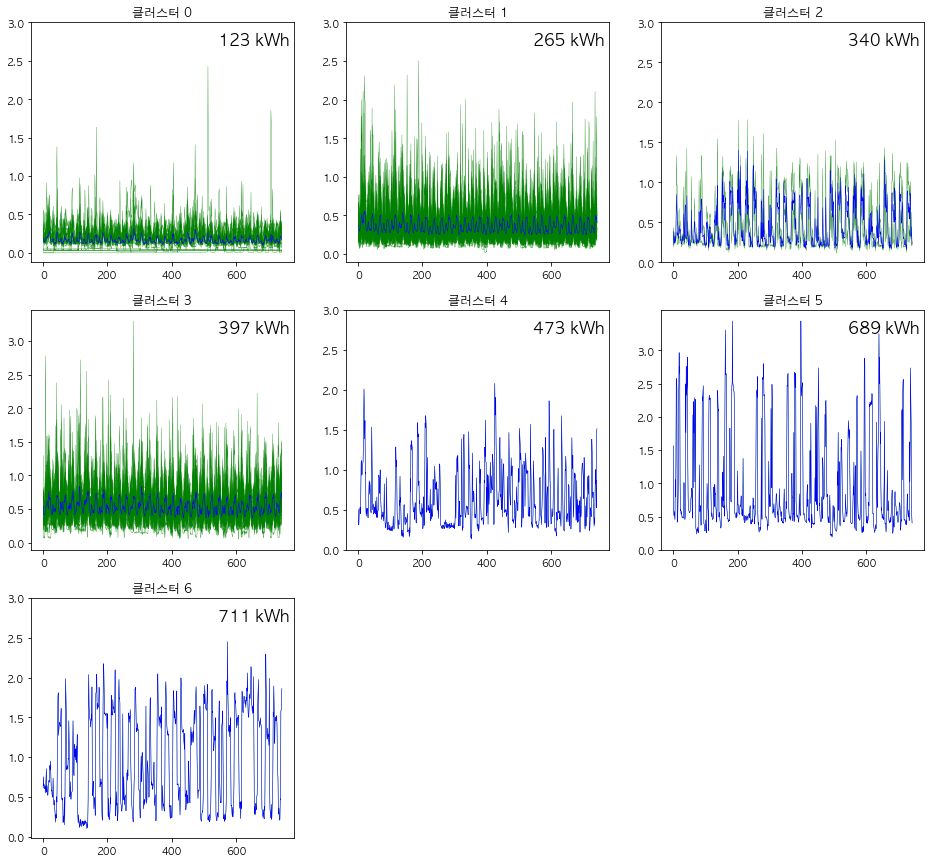

In [82]:
from src.KMeans import KMeans

kmeans = KMeans(datas=m_60.T.values, ver=3)
kmeans.fit()
kmeans.sorting()

kmeans.draw_plot()

# Anomaly 조정작업

In [102]:
group_df = ut.make_group_df(m_60, kmeans)
anomaly_df = ut.get_anomaly_df(group_df)
new_group_df = ut.adjust_anomaly_df(anomaly=anomaly_df,group_df=group_df, datas=m_60)

while True:
    anon_chk = ut.get_anomaly_df(new_group_df)
    
    if len(anon_chk) != 0:
        new_group_df = ut.adjust_anomaly_df(anomaly=anon_chk,group_df=group_df, datas=m_60)
    else: 
        break

0.4950151983485789


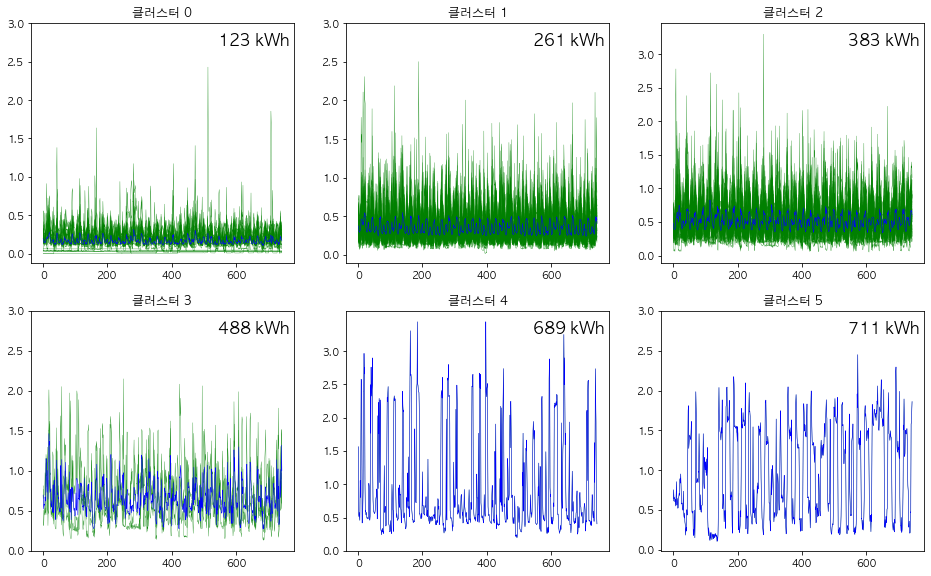

In [104]:
K = new_group_df['label'].value_counts().index.size

kmeans.K = K
kmeans.clusters_ = kmeans.clusters_[:K]
kmeans.labels_ = new_group_df['label'].values

kmeans.next_setting()

print(kmeans.ecv)
kmeans.draw_plot()

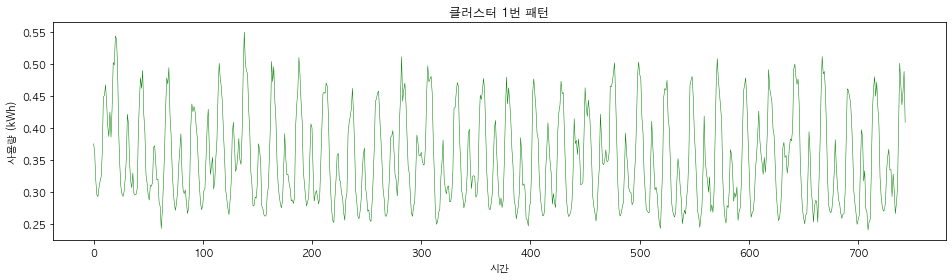

In [114]:
time_clusters = kmeans.clusters_

time_target = time_clusters[1]

plt.figure(figsize=(16, 4))

plt.plot(time_target, color='g', linewidth=0.5)
plt.title("클러스터 1번 패턴")
plt.ylabel("사용량 (kWh)")
plt.xlabel("시간")

plt.show()

# 시간대 Grouping

In [227]:
import datetime as dt

def time_grouping(target, time_size):
    times = [(start_time, start_time + (time_size-1)) for start_time in range(0,24,time_size)]
    time_index = m_60.index
    time_group = list()

    for start_time, end_time in times:
        time_group.append(
            target[(time_index.time >= dt.time(start_time,0)) 
                   & (time_index.time <= dt.time(end_time,0))].reshape(-1, time_size)
        )

    time_group = np.array(time_group)
    
    return time_group

In [228]:
target = time_target
time_group = time_grouping(target, 4)
time_group.shape

(6, 31, 4)

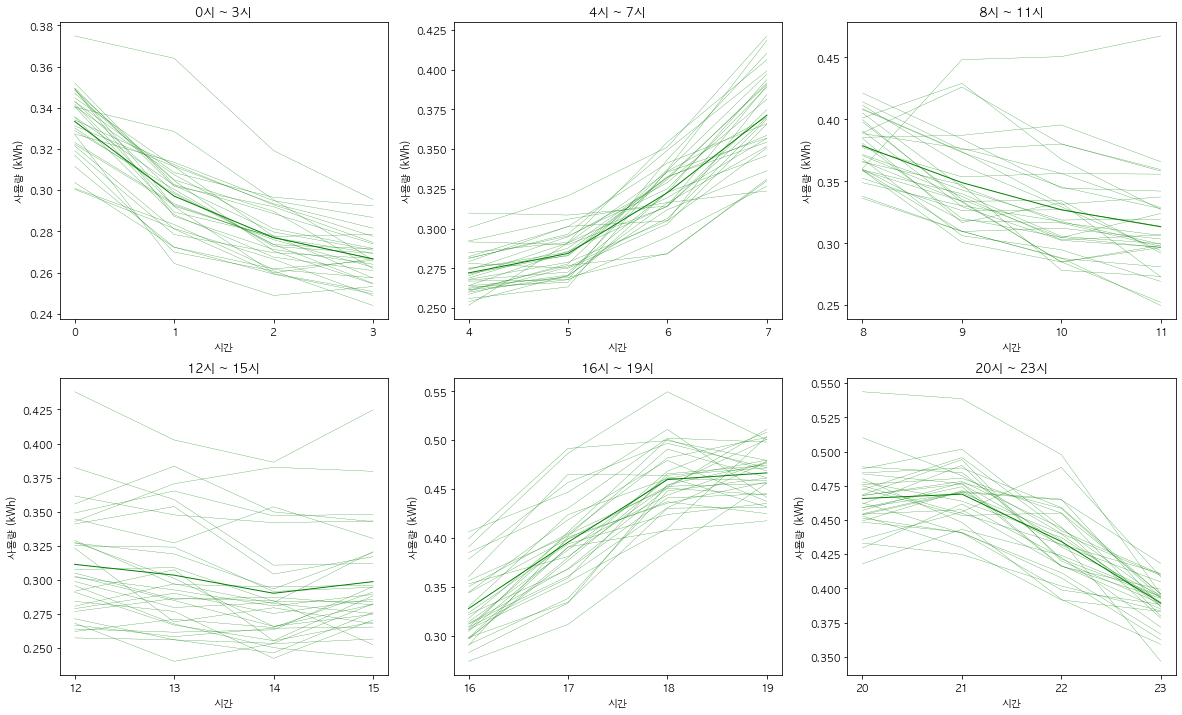

In [229]:
mean_time_group = time_group.mean(axis=1)

plt.figure(figsize=(20, 12))

for idx, group in enumerate(time_group):
    mean_group = mean_time_group[idx]
    start_time, end_time = times[idx]
    ax = plt.subplot(2, 3, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

# 요일별 Grouping

In [230]:
def day_grouping(target, day_index):
    days = ['월', '화', '수', '목', '금', '토', '일']
    day_group = list()

    for idx, day in enumerate(days):
        day_group.append(target[
            day_index.weekday == idx].reshape(-1, 24))

    return day_group

In [233]:
target = time_clusters[2]
day_index = m_60.index

day_group = day_grouping(target, day_index)
day_group[0]

array([[0.5149411764705883, 0.4462058823529413, 0.4097058823529412,
        0.3913529411764705, 0.3689411764705883, 0.3975588235294118,
        0.5138235294117647, 0.5033235294117648, 0.6165294117647059,
        0.5156176470588235, 0.5202352941176471, 0.46744117647058825,
        0.5152058823529411, 0.45382352941176474, 0.44997058823529423,
        0.4611764705882353, 0.5170882352941176, 0.5628235294117648,
        0.6703529411764704, 0.6596764705882353, 0.6928823529411763,
        0.688529411764706, 0.6305588235294117, 0.5786764705882353],
       [0.4736176470588235, 0.4176176470588236, 0.38364705882352945,
        0.3589705882352941, 0.35267647058823537, 0.3586764705882354,
        0.5286176470588235, 0.5143529411764706, 0.488735294117647,
        0.4740294117647059, 0.5119411764705881, 0.5231176470588232,
        0.5726470588235293, 0.5161470588235294, 0.4817941176470588,
        0.4698529411764706, 0.49279411764705877, 0.5887352941176472,
        0.6775882352941175, 0.6303823529411

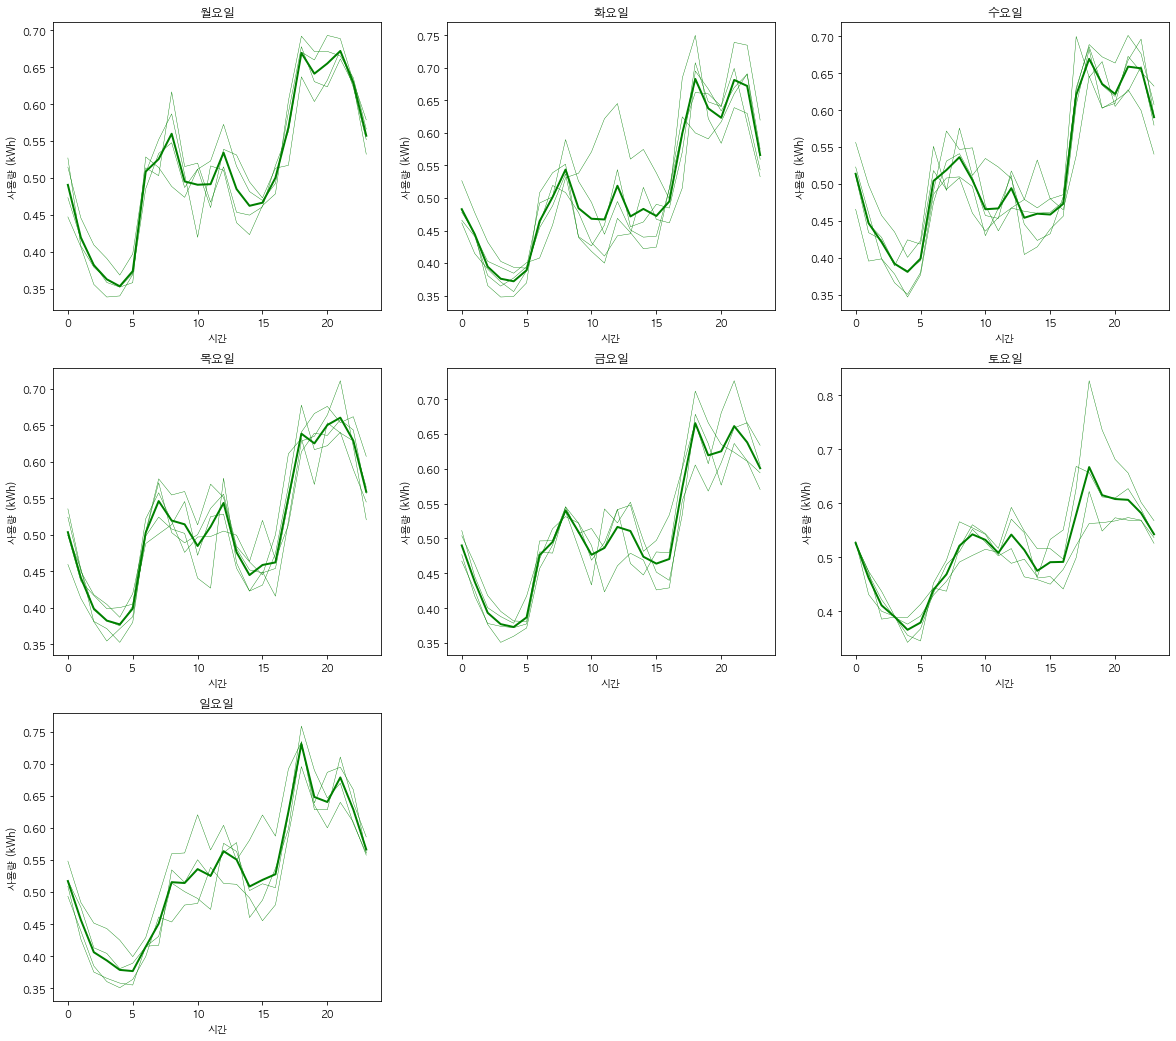

In [234]:
plt.figure(figsize=(20, 18))

for idx, group in enumerate(day_group):
    mean_group = group.mean(axis=0)
    day = days[idx]
    
    ax = plt.subplot(3, 3, idx+1)
    
    ax.plot(group.T, color='g', linewidth=0.4)
    ax.plot(mean_group, color='g', linewidth=2)
    ax.set_title("{}요일".format(day))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()